In [1]:
#!pip install n2v
#!pip install albumentations

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import glob
import zipfile
import cv2
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import albumentations as albu
import json

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


2023-05-01 22:50:26.930145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
datagen = N2V_DataGenerator()

In [2]:
INBREAST_PATH="/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast"
MIAS_PATH="/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS"
CBIS_DDSM_PATH="/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM"

In [4]:
def get_images_paths(path):
    images_path=[]
    for (filepath, _, files) in os.walk(path, topdown=False):
        for file in files:
            if file.endswith(".png") and "MASK" not in file:
                images_path.append(os.path.join(filepath,file))
    return images_path
    

inbreast_files = get_images_paths(INBREAST_PATH)
cbis_ddsm_files = get_images_paths(MIAS_PATH)
mias_files = get_images_paths(CBIS_DDSM_PATH)

# To prevent unbalanced data from different datasets
samples_per_dataset=min(500, len(inbreast_files), len(cbis_ddsm_files), len(mias_files))

print(f"Samples per dataset = {samples_per_dataset}")

inbreast_files = np.random.choice(inbreast_files, size=samples_per_dataset, replace=False)
cbis_ddsm_files = np.random.choice(cbis_ddsm_files, size=samples_per_dataset, replace=False)
mias_files = np.random.choice(mias_files, size=samples_per_dataset, replace=False)

all_files = np.concatenate((inbreast_files, cbis_ddsm_files, mias_files), axis=None)

np.random.shuffle(all_files)

n_samples = len(all_files)
partitions = [int(0.75*n_samples), int(0.85*n_samples)]


train_list_files, val_list_files, test_list_files = np.split(all_files, partitions)

Samples per dataset = 322


In [5]:
train_list_files = tf.data.Dataset.from_tensor_slices(train_list_files)
val_list_files = tf.data.Dataset.from_tensor_slices(val_list_files)
test_list_files = tf.data.Dataset.from_tensor_slices(test_list_files)

2023-05-01 11:04:39.789079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 11:04:39.805540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 11:04:39.805754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
input_shape=(1600,1600)

In [86]:
def load_img_from_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=1)
    img = tf.image.resize_with_pad(img,input_shape[0],input_shape[1])
    return img

def apply_clahe(image):
    image = image.astype("uint8")
    aug_img = albu.CLAHE(clip_limit=(1,10),p=1)(image = image)["image"]
    return aug_img.astype("uint8")

@tf.function
def preprocess_img(image):
    image = tf.numpy_function(apply_clahe, inp=[image], Tout=[tf.uint8])
    return image[0]
    

def load_and_process(path_list, batch_size=32):
    ds = path_list.map(load_img_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    # optimize performance
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    
    return ds

train_imgs = load_and_process(train_list_files, batch_size=1)
val_imgs = load_and_process(val_list_files, batch_size=1)
test_imgs = load_and_process(val_list_files, batch_size=1)

2023-05-01 12:31:02.127476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:31:02.127785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:31:12.181507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 701 of 1000
2023-05-01 12:31:12.460526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


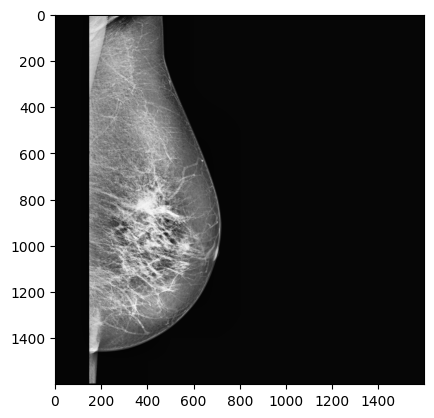

2023-05-01 12:31:12.753844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:31:12.754127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


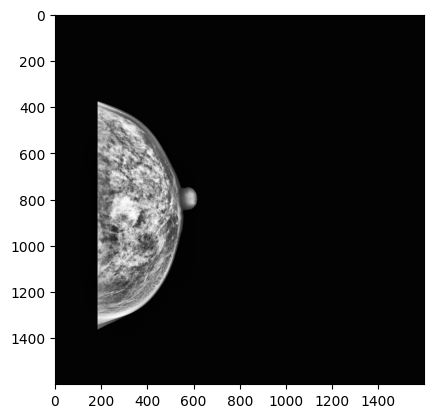

In [87]:
plt.imshow((next(iter(train_imgs.take(1))))[0], cmap="gray")
plt.show()
plt.imshow((next(iter(val_imgs.take(1))))[0], cmap="gray")
plt.show()

In [8]:
# We will use the first image to extract training patches and store them in 'X'
patch_shape = (64,64)

X = datagen.generate_patches_from_list(train_imgs, shape=patch_shape, num_patches_per_img=12)

# We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(val_imgs, shape=patch_shape, num_patches_per_img=12)

2023-05-01 11:04:53.531183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:04:53.531484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:05:03.564304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 694 of 1000
2023-05-01 11:05:03.930503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

2023-05-01 11:05:07.738851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:05:07.739069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

In [9]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/32), train_epochs=50, train_loss='mse', batch_norm=True, 
                   train_batch_size=16, n2v_perc_pix=0.198, n2v_patch_shape=patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

In [10]:
# a name used to identify the model
model_name = 'n2v_2D'
# the base directory in which our model will live
basedir = '/kaggle/working/models'

os.makedirs(basedir, exist_ok=True)
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

/usr/local/lib/python3.8/dist-packages/n2v/models/n2v_standard.py:429: UserWarning: output path for model already exists, files may be overwritten: /kaggle/working/models/n2v_2D
  warnings.warn(


In [11]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 9312/9312 [00:02<00:00, 4116.69it/s]

Epoch 1/50



2023-05-01 11:05:14.808980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:05:17.836179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-01 11:05:19.590305: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7faaa047c480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-01 11:05:19.590348: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-05-01 11:05:19.654499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-01 11:05:19

2172/2172 [==============================] - 47s 17ms/step - loss: 0.0535 - n2v_mse: 0.0535 - n2v_abs: 0.1275 - val_loss: 0.0128 - val_n2v_mse: 0.0128 - val_n2v_abs: 0.0600 - lr: 4.0000e-04
Epoch 2/50
2172/2172 [==============================] - 37s 17ms/step - loss: 0.0232 - n2v_mse: 0.0232 - n2v_abs: 0.0832 - val_loss: 0.0323 - val_n2v_mse: 0.0323 - val_n2v_abs: 0.1559 - lr: 4.0000e-04
Epoch 3/50
2172/2172 [==============================] - 38s 18ms/step - loss: 0.0153 - n2v_mse: 0.0153 - n2v_abs: 0.0656 - val_loss: 0.0053 - val_n2v_mse: 0.0053 - val_n2v_abs: 0.0369 - lr: 4.0000e-04
Epoch 4/50
2172/2172 [==============================] - 39s 18ms/step - loss: 0.0114 - n2v_mse: 0.0114 - n2v_abs: 0.0569 - val_loss: 0.0061 - val_n2v_mse: 0.0061 - val_n2v_abs: 0.0437 - lr: 4.0000e-04
Epoch 5/50
2172/2172 [==============================] - 39s 18ms/step - loss: 0.0098 - n2v_mse: 0.0098 - n2v_abs: 0.0524 - val_loss: 0.0057 - val_n2v_mse: 0.0057 - val_n2v_abs: 0.0368 - lr: 4.0000e-04
Epoch 

Epoch 27/50
2172/2172 [==============================] - 40s 19ms/step - loss: 0.0047 - n2v_mse: 0.0047 - n2v_abs: 0.0323 - val_loss: 0.0051 - val_n2v_mse: 0.0051 - val_n2v_abs: 0.0357 - lr: 2.0000e-04
Epoch 28/50
2172/2172 [==============================] - 40s 19ms/step - loss: 0.0046 - n2v_mse: 0.0046 - n2v_abs: 0.0318 - val_loss: 0.0061 - val_n2v_mse: 0.0061 - val_n2v_abs: 0.0378 - lr: 2.0000e-04
Epoch 29/50
2172/2172 [==============================] - 40s 18ms/step - loss: 0.0046 - n2v_mse: 0.0046 - n2v_abs: 0.0317 - val_loss: 0.0050 - val_n2v_mse: 0.0050 - val_n2v_abs: 0.0313 - lr: 2.0000e-04
Epoch 30/50
2172/2172 [==============================] - 40s 19ms/step - loss: 0.0047 - n2v_mse: 0.0047 - n2v_abs: 0.0320 - val_loss: 0.0058 - val_n2v_mse: 0.0058 - val_n2v_abs: 0.0363 - lr: 2.0000e-04
Epoch 31/50
2172/2172 [==============================] - 40s 18ms/step - loss: 0.0046 - n2v_mse: 0.0046 - n2v_abs: 0.0314 - val_loss: 0.0052 - val_n2v_mse: 0.0052 - val_n2v_abs: 0.0345 - lr: 2

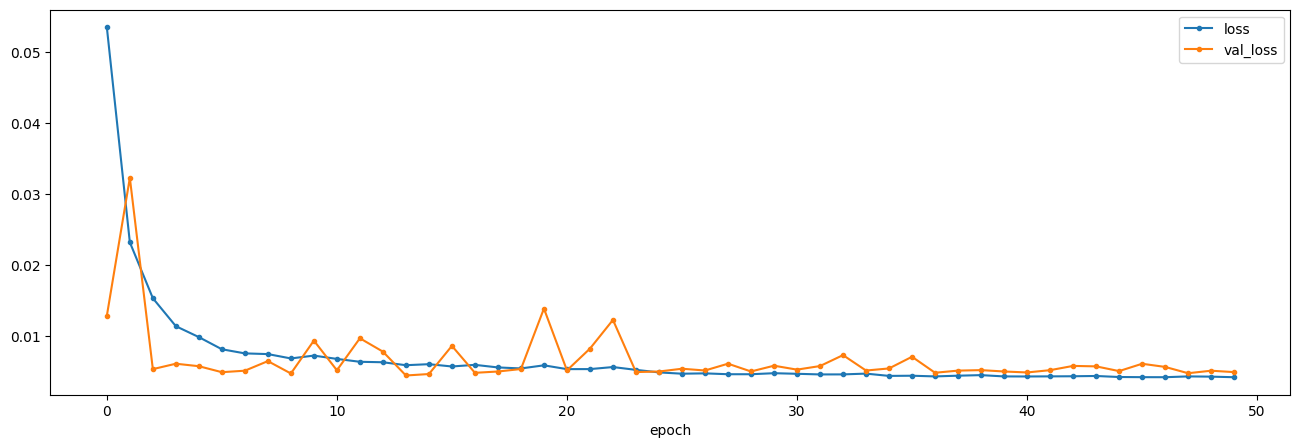

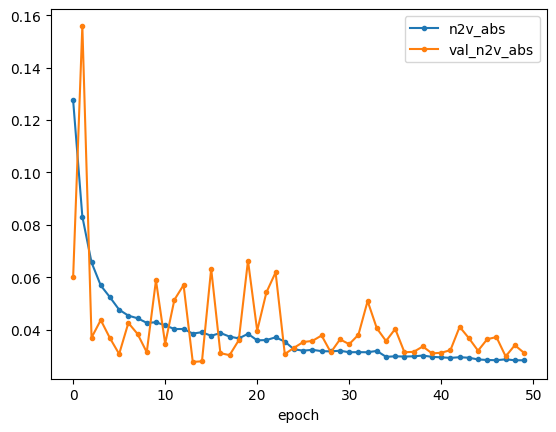

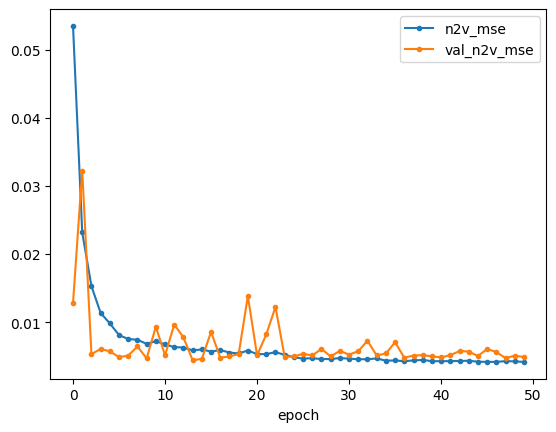

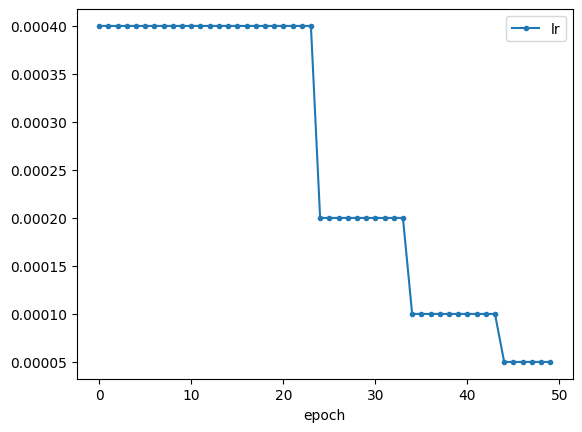

In [15]:
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);
plot_history(history,['n2v_abs','val_n2v_abs']);
plot_history(history,['n2v_mse','val_n2v_mse']);
plot_history(history,['lr']);

2023-05-01 12:15:06.938852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:06.939358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


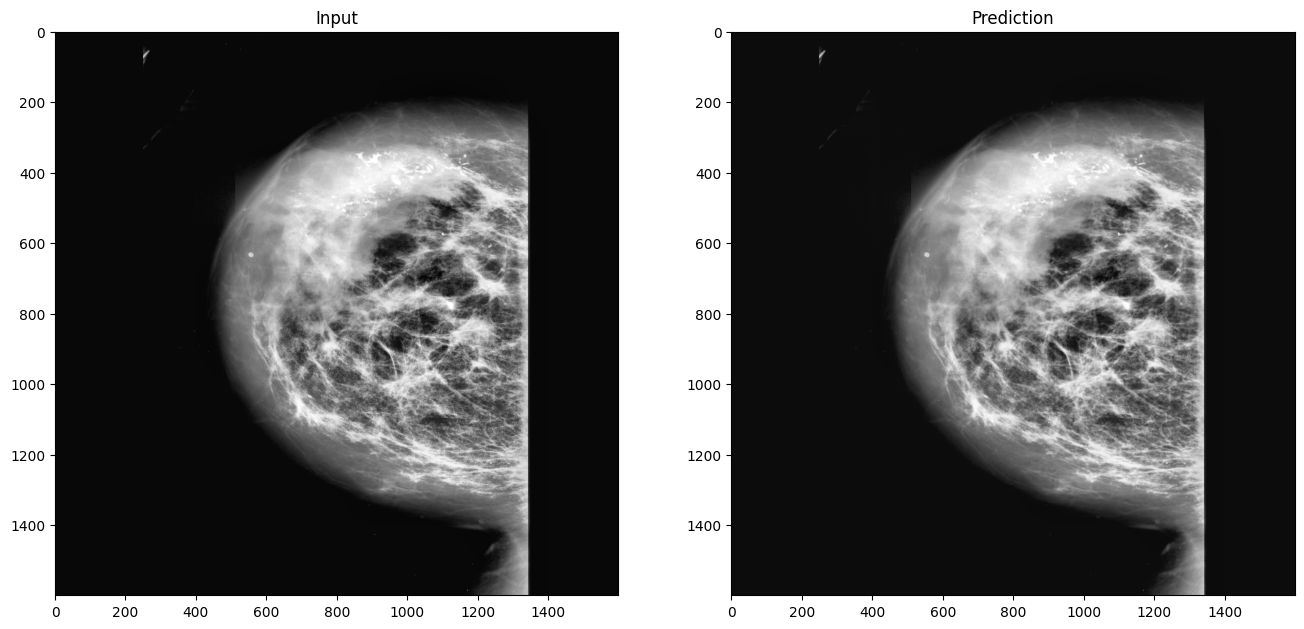

2023-05-01 12:15:09.216381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:09.216643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


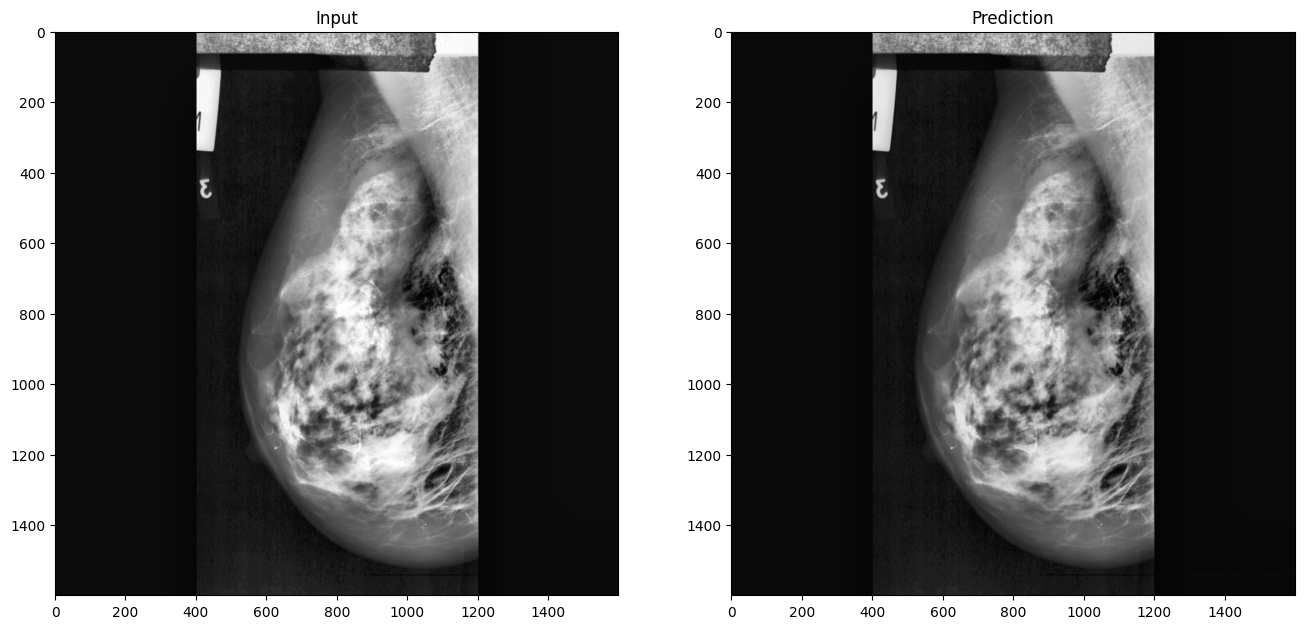

2023-05-01 12:15:11.510513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:11.510759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


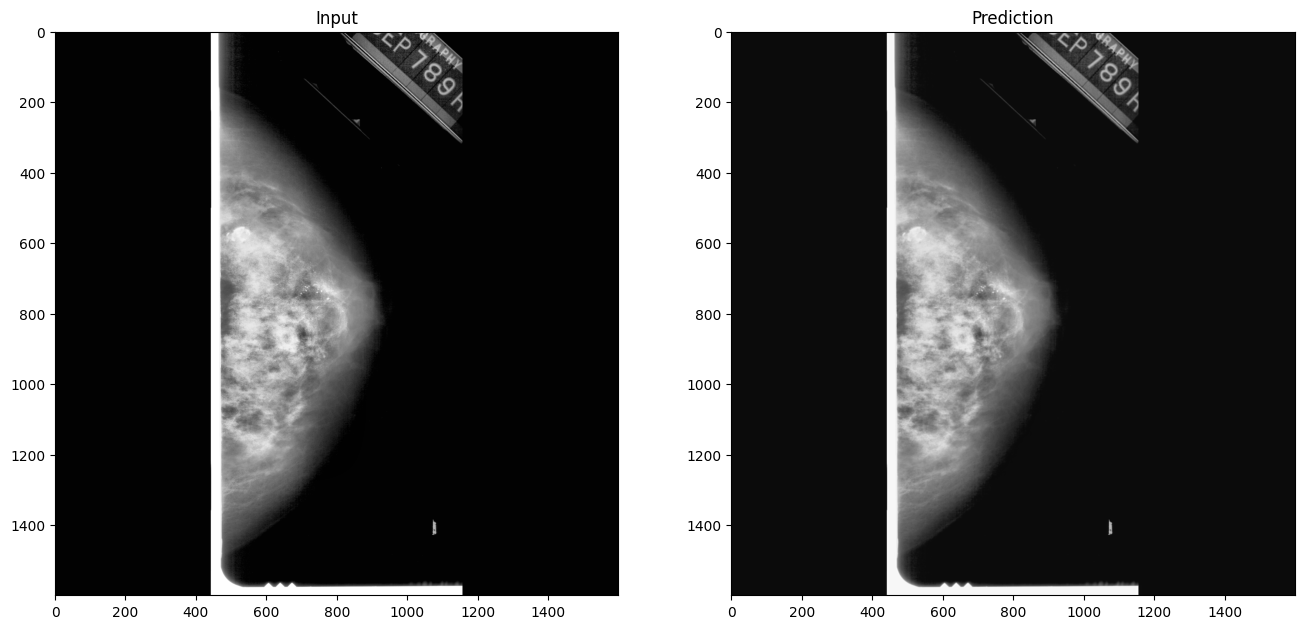

2023-05-01 12:15:13.789941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:13.790369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step


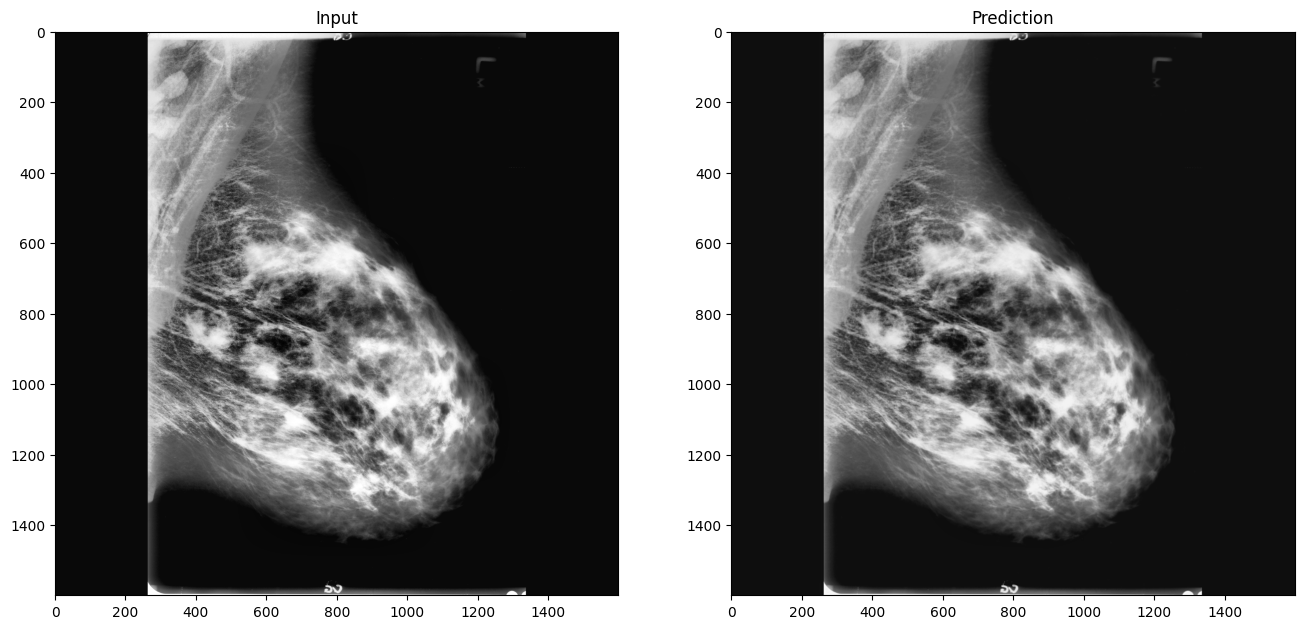

2023-05-01 12:15:16.045258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:16.045558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step


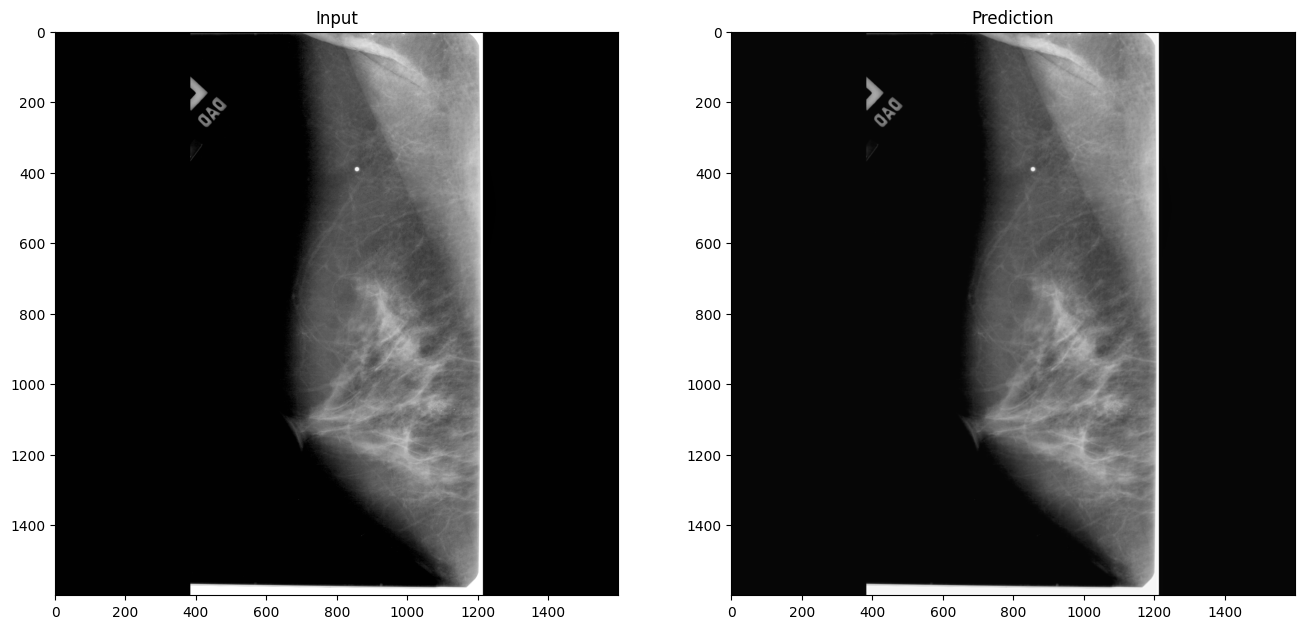

2023-05-01 12:15:18.302207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:18.302469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


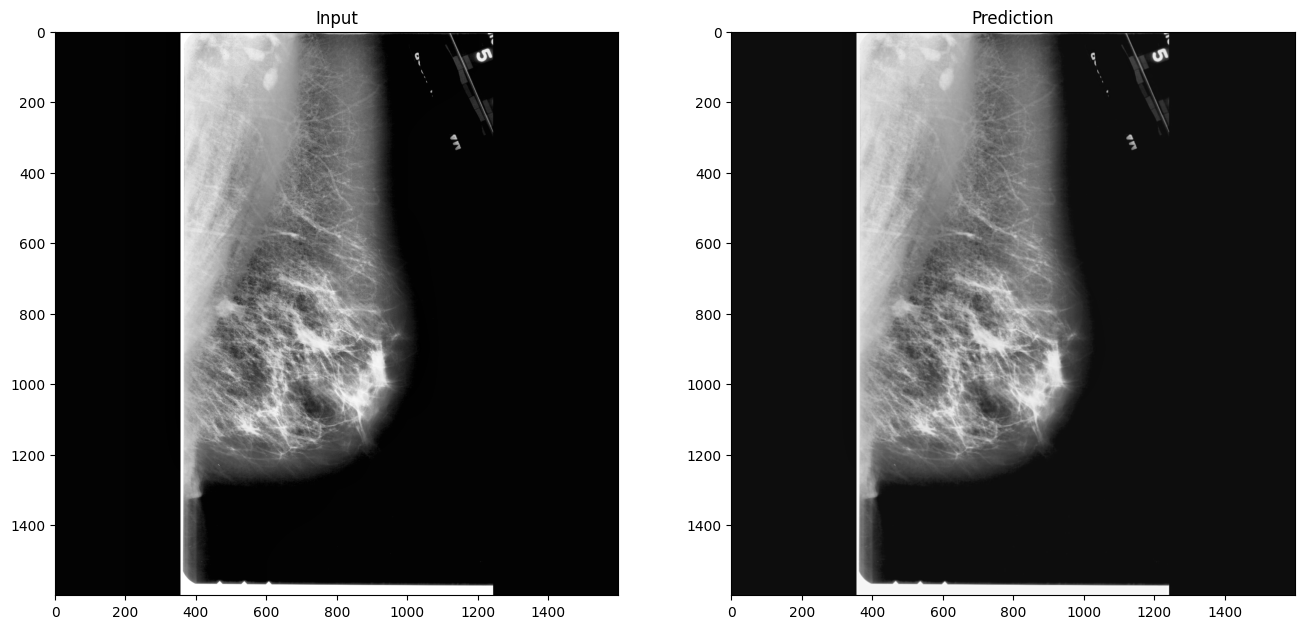

2023-05-01 12:15:20.557725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:20.557990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


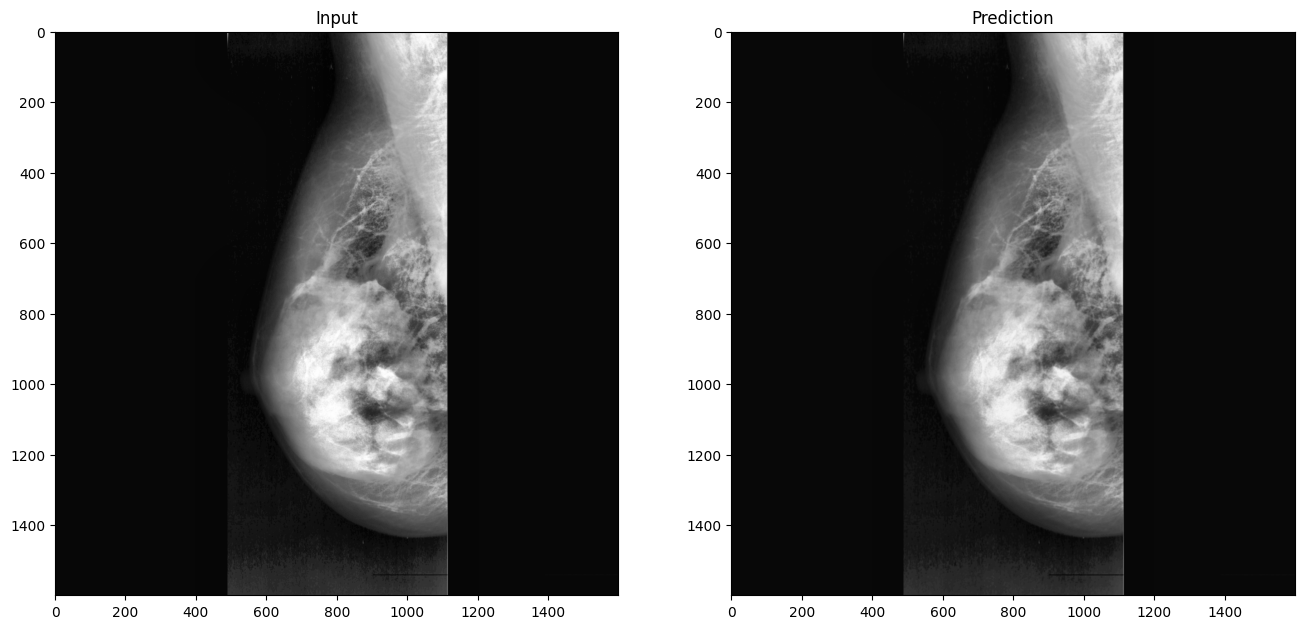

2023-05-01 12:15:23.034905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:23.035173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step


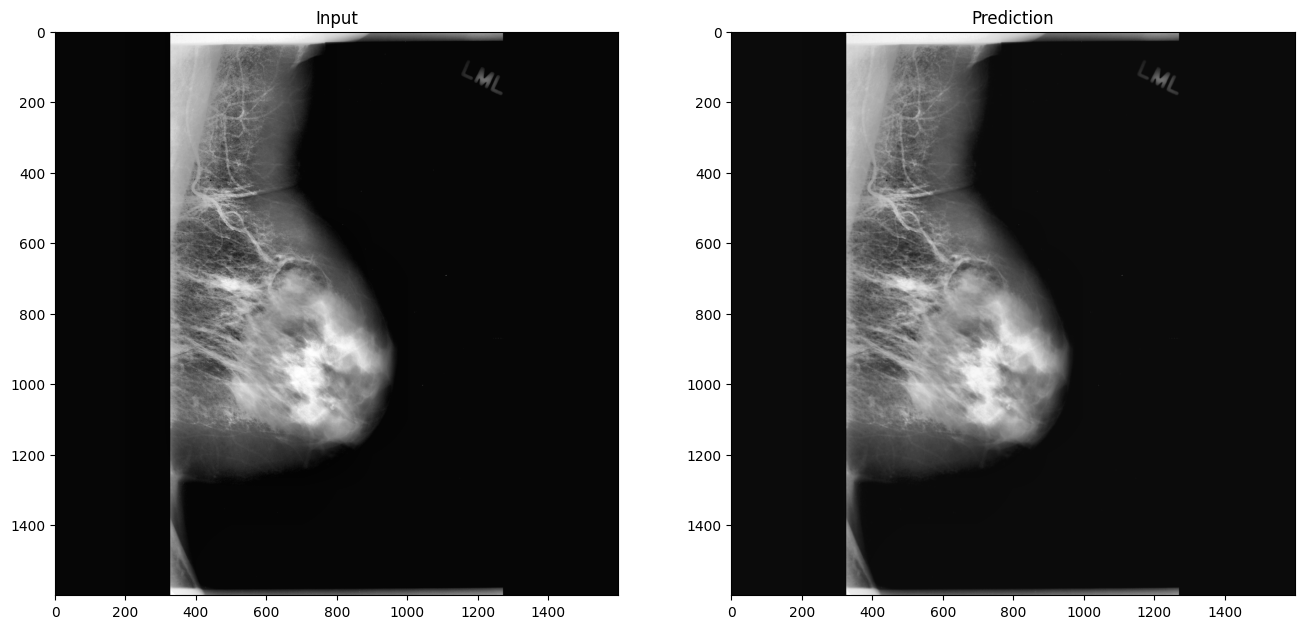

2023-05-01 12:15:25.389463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:25.389753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step


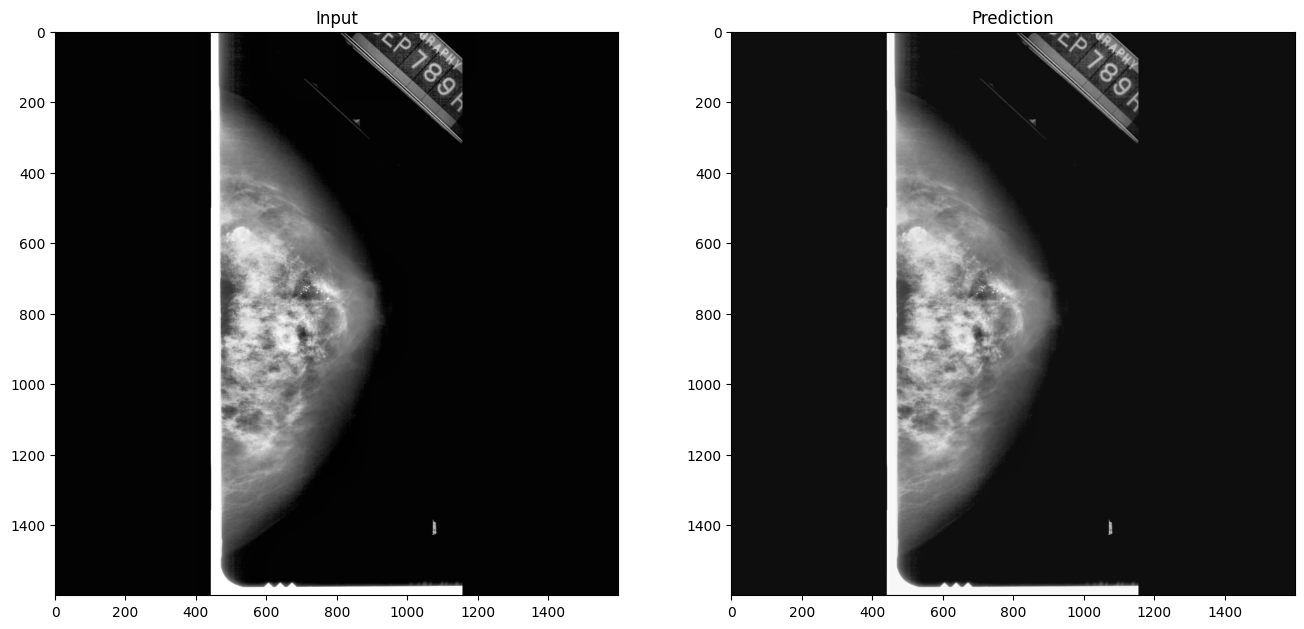

2023-05-01 12:15:27.760926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:27.761180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


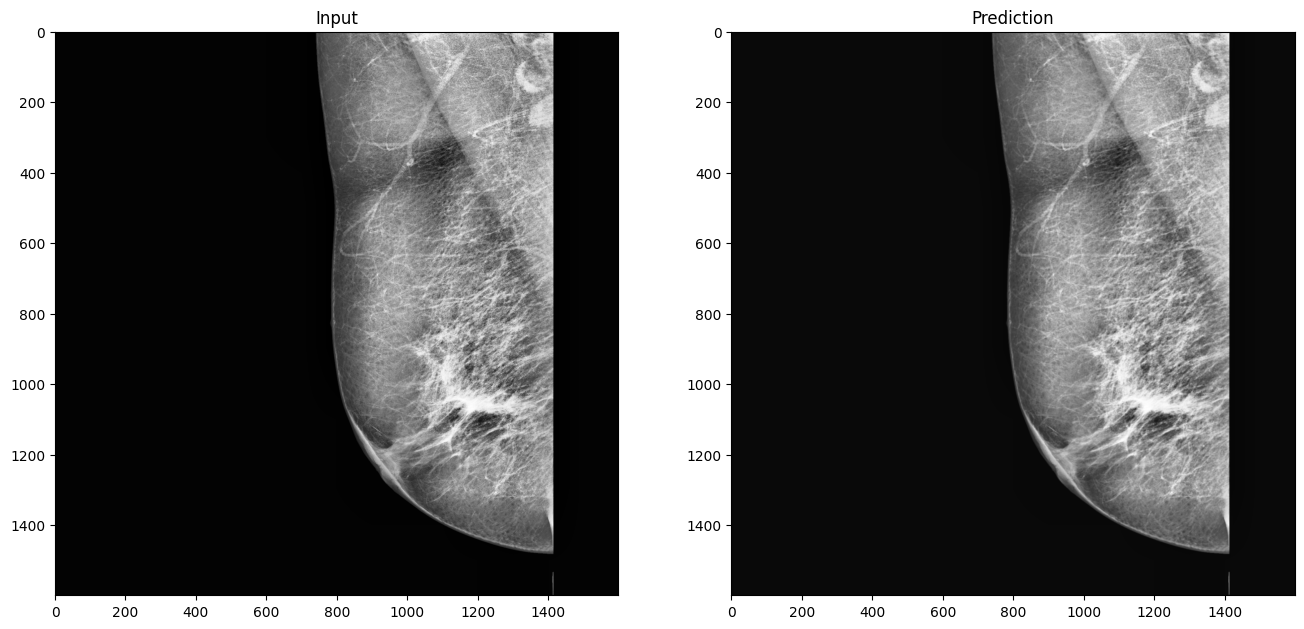

In [63]:
# We can optionally apply an 8bits coding for color
def to_8_bits_color(img_array):
    norm_img_array = img_array / \
        img_array.max() * 255
    return norm_img_array

for i in range(10):
    input_val=np.array(next(iter(test_imgs.take(1)))[0]).reshape(input_shape)
    pred_val=model.predict(input_val, axes="YX")

    # Let's look at the results.
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(input_val,cmap="gray")
    plt.title('Input');
    plt.subplot(1,2,2)
    plt.imshow(pred_val,cmap="gray")
    plt.title('Prediction');
    plt.show()
    cv2.imwrite(f"/kaggle/working/input_n2v_{i+1}.png", input_val)
    cv2.imwrite(f"/kaggle/working/predict_n2v_{i+1}.png", pred_val)

In [4]:
# a name used to identify the model
model_name = 'n2v_2D'
# the base directory in which our model will live
basedir = '/kaggle/working/models'

# We are now creating our network model.
model = N2V(None, model_name, basedir=basedir)

2023-05-01 22:50:43.101820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 22:50:43.107910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 22:50:43.108212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loading network weights from 'weights_best.h5'.


In [5]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = np.array(image).astype("uint8")
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)



In [6]:
from tensorflow.keras.utils import load_img

def load_img_from_path_no_resize(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=1)
    return img

def resize_correct_side(image):
    h_in = image.shape[0]
    w_in = image.shape[1]
    
    input_is_wider = h_in <= w_in
    output_is_wider = input_shape[0] <= input_shape[1]
    
    increase_width_first = abs(h_in/input_shape[0] - 1.0) < abs(w_in/input_shape[1] - 1.0)
    N = input_shape[1] if increase_width_first else input_shape[0]
    if input_is_wider != output_is_wider:
        return albu.LongestMaxSize(max_size=N)
    else:
        return albu.SmallestMaxSize(max_size=N)
    

def apply_albumentations(image, bboxes):
    image = image.astype("uint8")    
    
    transform = albu.Compose([
        resize_correct_side(image),
        albu.PadIfNeeded(min_height=input_shape[0], min_width=input_shape[1], border_mode=0, value=(0,0,0)),
        albu.CLAHE(clip_limit=(1,10),p=1),
        #albu.Rotate(p=1, border_mode=cv2.BORDER_CONSTANT,)
        ],
        bbox_params=albu.BboxParams(format='coco', label_fields=["abnormality"])
    )
    
    transform_data = transform(image = image, bboxes=bboxes, abnormality=[1]*len(bboxes))
    new_img = transform_data["image"]
    new_boxes = transform_data["bboxes"]
    return new_img.astype("uint8"), new_boxes

@tf.function
def preprocess_img_and_boxes(image, boxes):
    image, boxes = tf.numpy_function(apply_albumentations, inp=[image, boxes], Tout=[tf.uint8, tf.double])
    return image, boxes

In [313]:
##########################################################################################
################################   TEST   ################################################
##########################################################################################

# get all paths
inbreast_files = get_images_paths(INBREAST_PATH)
cbis_ddsm_files = get_images_paths(MIAS_PATH)
mias_files = get_images_paths(CBIS_DDSM_PATH)

all_files = np.concatenate((inbreast_files, cbis_ddsm_files, mias_files), axis=None)


counter=0
for path in all_files:
    filename=path.split("/")[-1]
    img = load_img_from_path_no_resize(path)
    boxes=[[10,10,10,10]]
    preprocessed_img, preprocessed_boxes = preprocess_img_and_boxes(img, boxes)
    pred_val=model.predict(np.array(preprocessed_img).reshape(input_shape), axes="YX")
    counter +=1
    print(path)
    print(counter, end="\r", flush=True)
   
    #cv2.imwrite(f"/kaggle/working/input_n2v_{i+1}.png", input_val)
    #visualize(pred_val, preprocessed_boxes,[1],{1: "Abnormality"})

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24055355.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50998349.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/53582449.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/20588562.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/51049516.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24055445.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50996736.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22614236.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50999094.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/20588334.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24065860.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22670511.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24065557.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24055464.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/20586960.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/30011674.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22613702.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22678622.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22614379.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22670832.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/53587599.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50997223.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50994137.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/20587518.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/51049628.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50997796.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22614266.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50999246.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24065914.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/27829188.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50998634.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/20587320.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50996406.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50999121.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22580038.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/20587690.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22580098.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/53582710.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24065461.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50994408.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/24065707.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/50997597.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22614431.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast/22670324.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographi

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb022.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb151.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb308.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb181.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb113.png
The i

1/1 [==============================] - 0s 20ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb034.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb223.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb114.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb059.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb314.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [

1/1 [==============================] - 0s 21ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb241.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb097.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb285.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb052.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb218.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [

1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb303.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb279.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb203.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb164.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb109.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [

1/1 [==============================] - 0s 23ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb172.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb170.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb197.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS/mdb039.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_01757_RIGHT_CC.png
The input image is of type uint8 and will be casted to 

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Calc-Training_P_00013_RIGHT_MLO.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_01155_RIGHT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_00797_RIGHT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Calc-Training_P_00965_LEFT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [====

1/1 [==============================] - 0s 25ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Test_P_00766_LEFT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 25ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Test_P_01108_RIGHT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_00518_LEFT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Calc-Test_P_00876_LEFT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies

1/1 [==============================] - 0s 20ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_01540_LEFT_MLO.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_01850_RIGHT_MLO.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Calc-Training_P_02405_RIGHT_MLO.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Calc-Training_P_00024_LEFT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbrea

1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_00451_LEFT_MLO.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Calc-Training_P_00877_LEFT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Mass-Training_P_01717_LEFT_CC.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM/Calc-Test_P_01621_LEFT_MLO.png
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
/kaggle/input/mias-cbis-ddsm-inbreast/Mamm

KeyboardInterrupt: 

In [7]:
with open(os.path.join(INBREAST_PATH,"roi_images.json"),"r") as f:
    rois_inbreast = json.load(f)
    
with open(os.path.join(CBIS_DDSM_PATH,"roi_images.json"),"r") as f:
    rois_cbis_ddsm = json.load(f)
    
with open(os.path.join(MIAS_PATH,"roi_images.json"),"r") as f:
    rois_mias = json.load(f)

print(len(rois_inbreast), len(rois_cbis_ddsm), len(rois_mias))

343 3103 111


In [8]:
# generate YOLO data
YOLO_DIR_IMAGES="/kaggle/working/yolo_data/images"
YOLO_DIR_LABELS="/kaggle/working/yolo_data/labels"

os.makedirs(YOLO_DIR_IMAGES, exist_ok=True)
os.makedirs(YOLO_DIR_LABELS, exist_ok=True)

datasets_rois = {"mias": rois_mias, "inbreast": rois_inbreast, "cbis_ddsm": rois_cbis_ddsm}

dataset_to_dir = {"mias": MIAS_PATH,"inbreast": INBREAST_PATH,"cbis_ddsm": CBIS_DDSM_PATH}

from collections import defaultdict

##Check how balanced are abnormalities
types_ab = defaultdict(int)
for dataset, rois in datasets_rois.items():
    for k, rois in rois.items():
        for roi in rois:
            types_ab[roi["type"]] += 1
types_ab

defaultdict(int,
            {'CIRC': 24,
             'MISC': 15,
             'ASYM': 15,
             'ARCH': 19,
             'SPIC': 19,
             'CALC': 27,
             'Calcification': 7142,
             'Spiculated Region': 14,
             'Mass': 1812,
             'Cluster': 27,
             'Assymetry': 1,
             'Asymmetry': 5,
             'Distortion': 3,
             'Calcifications': 1,
             'Unnamed': 2,
             'Point 3': 1,
             'Point 1': 1,
             'Spiculated region': 1,
             '': 1,
             'Espiculated Region': 1,
             'Calc': 1872})

In [9]:
name_2_name= {'CIRC': "Mass",
              'MISC': "Unknown",
              'ASYM': "Assymetry",
              'ARCH': "Distortion",
              'SPIC': "Spiculated Region",
              'CALC': "Calcification",
              'Calcification': "Calcification",
              'Spiculated Region': "Spiculated Region",
              'Mass': "Mass",
              'Cluster': "Cluster",
              'Assymetry': "Assymetry",
              'Asymmetry': "Assymetry",
              'Distortion': "Distortion",
              'Calcifications': "Calcification",
              'Unnamed': "Unknown",
              'Point 3': "Unknown",
              'Point 1': "Unknown",
              'Spiculated region': "Spiculated Region",
              '': "Unknown",
              'Calc': "Calcification",
              'Espiculated Region': "Spiculated Region"}

In [10]:
def generate_yolo_box(bboxes, image_shape):
    bboxes = np.array(bboxes)
    #Calc the xcenter and ycenter. bboxes = [xmin, ymin, w, d]
    xcenter = bboxes[0] + bboxes[2]/2
    ycenter = bboxes[1] + bboxes[3]/2
    
    #Calc proportion to image
    xcenter = xcenter / image_shape[1]
    ycenter = ycenter / image_shape[0]
    w = bboxes[2] / image_shape[1]
    h = bboxes[3] / image_shape[0]
    return xcenter, ycenter, w, h   

In [11]:
def check_type_abnormality(ab):
    return name_2_name[ab["type"]] in ["Calcification", "Mass"]

count=0
for dataset, rois in datasets_rois.items():
    for file, roi in rois.items():
        try:
            roi = list(filter(lambda r: check_type_abnormality(r), roi))
            boxes=[]

            for box in roi:
                boxes.append([box["x"], box["y"], box["w"], box["h"]])

            path = os.path.join(dataset_to_dir[dataset], file+".png")
            img = load_img_from_path_no_resize(path)
            preprocessed_img, preprocessed_boxes = preprocess_img_and_boxes(img, boxes)
            denoised_image=model.predict(np.array(preprocessed_img).reshape(input_shape), axes="YX")
            with open(os.path.join(YOLO_DIR_LABELS, file+".txt"),"w") as f:
                for box in preprocessed_boxes:
                    yolo_box = generate_yolo_box(box, denoised_image.shape)
                    f.write(f"Abnormality {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]} \n")

            cv2.imwrite(f"{os.path.join(YOLO_DIR_IMAGES, file+'.png')}", denoised_image)
        except:
            count+=1
            print(f"{count} files out")

print(f"{count} files had an issue")

The input image is of type uint8 and will be casted to float32 for prediction.


2023-05-01 22:51:03.386801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-01 22:51:08.490068: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-01 22:51:09.268329: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 8s 8s/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
The input image is of type uint

1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint

1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 25ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 33ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

2023-05-01 22:53:12.405463: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: Expected x_max for bbox (0.99921875, 0.4375, 1.001171875, 0.43900240384615385, 1) to be in the range [0.0, 1.0], got 1.001171875.
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_80553/3820921144.py", line 35, in apply_albumentations
    transform_data = transform(image = image, bboxes=bboxes, abnormality=[1]*len(bboxes))

  File "/usr/local/lib/python3.8/dist-packages/albumentations/core/composition.py", line 202, in __call__
    p.preprocess(data)

  File "/usr/local/lib/python3.8/dist-packages/albumentations/core/utils.py", line 83, in preprocess
    data[data_name] = self.check_and_convert(data[data_

1 files out
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for pred

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
2 files out
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step


2023-05-01 22:53:36.096764: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: Expected x_max for bbox (0.9984375, 0.7154447115384616, 1.000390625, 0.7169471153846154, 1) to be in the range [0.0, 1.0], got 1.000390625.
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_80553/3820921144.py", line 35, in apply_albumentations
    transform_data = transform(image = image, bboxes=bboxes, abnormality=[1]*len(bboxes))

  File "/usr/local/lib/python3.8/dist-packages/albumentations/core/composition.py", line 202, in __call__
    p.preprocess(data)

  File "/usr/local/lib/python3.8/dist-packages/albumentations/core/utils.py", line 83, in preprocess
    data[data_name] = self.check_and_convert(

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 28ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint

1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint

1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 27ms/step
The input image is of type uint

1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint

1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 29ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 28ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 33ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 35ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 25ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 33ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint

1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 29ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 25ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 27ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 28ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 29ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 29ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 25ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 28ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint

1/1 [==============================] - 0s 29ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 28ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 25ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 23ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 25ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 26ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 30ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 29ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint

1/1 [==============================] - 0s 21ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 20ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step
The input image is of type uint